## CSCI 470 Activities and Case Studies

1. For all activities, you are allowed to collaborate with a partner. 
1. For case studies, you should work individually and are **not** allowed to collaborate.

By filling out this notebook and submitting it, you acknowledge that you are aware of the above policies and are agreeing to comply with them.

Some considerations with regard to how these notebooks will be graded:

1. You can add more notebook cells or edit existing notebook cells other than "# YOUR CODE HERE" to test out or debug your code. We actually highly recommend you do so to gain a better understanding of what is happening. However, during grading, **these changes are ignored**. 
2. You must ensure that all your code for the particular task is available in the cells that say "# YOUR CODE HERE"
3. Every cell that says "# YOUR CODE HERE" is followed by a "raise NotImplementedError". You need to remove that line. During grading, if an error occurs then you will not receive points for your work in that section.
4. If your code passes the "assert" statements, then no output will result. If your code fails the "assert" statements, you will get an "AssertionError". Getting an assertion error means you will not receive points for that particular task.
5. If you edit the "assert" statements to make your code pass, they will still fail when they are graded since the "assert" statements will revert to the original. Make sure you don't edit the assert statements.
6. We may sometimes have "hidden" tests for grading. This means that passing the visible "assert" statements is not sufficient. The "assert" statements are there as a guide but you need to make sure you understand what you're required to do and ensure that you are doing it correctly. Passing the visible tests is necessary but not sufficient to get the grade for that cell.
7. When you are asked to define a function, make sure you **don't** use any variables outside of the parameters passed to the function. You can think of the parameters being passed to the function as a hint. Make sure you're using all of those variables.
8. Finally, **make sure you run "Kernel > Restart and Run All"** and pass all the asserts before submitting. If you don't restart the kernel, there may be some code that you ran and deleted that is still being used and that was why your asserts were passing.

# Deep Learning - Convolutional Neural Networks

In this exercise we'll compare a simple fully connected feed forward neural network with a convolutional neural network at predicting the [digits drawn in a 28x28 pixel image](http://yann.lecun.com/exdb/mnist/). 

Note that each sample we're using is a grayscale image - that means that each sample is a matrix of values whereas previously our samples had been vectors. You will need to modify the data to work with this accordingly. For example, keras' [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layers expect their inputs to be vectors so whenever you're using a [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer, make sure you convert its inputs to a vector. In keras, you can do that using the [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) layer. For more complex changes where you want to cusomize the exact shape of the values, you can use the [Reshape](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Reshape) layer.

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10, mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt

np.random.seed(0)

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
s1 = x_train.shape
s2 = x_test.shape
print(f"The mnist data was loaded with {s1[0]} training samples and {s2[0]} testing samples. Each sample is a {s1[1]} x {s1[2]} pixel image.")


The mnist data was loaded with 60000 training samples and 10000 testing samples. Each sample is a 28 x 28 pixel image.


In [4]:
# Here's an example hand drawn digit's image
example = x_train[0]
example

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

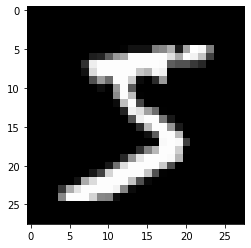

In [5]:
# Now let's plot that matrix to better understand what's happening here...
plt.imshow(example, cmap="gray")

In [6]:
# Here are all the unique labels in the data
# We're predicting the digit in an image and we have images from all digits
set(y_test)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [7]:
def calculate_conv_shape(X, K, padding=0, stride=1):
    """Calculate the shape of the output of a convolution 
    
    Args:
        X (np.array): The input matrix
        K (np.array): The filter matrix
        padding (int, optional): Defaults to 0. The padding dimension
        stride (int, optional): Defaults to 1. The stride of the convolution
    
    Returns:
        tuple: The shape of the convolution output, height then width
    """
    return (int(((X.shape[0]-K.shape[0]+2*padding)/(stride))+1), int(((X.shape[1]-K.shape[1]+2*padding)/(stride))+1))

In [8]:
sharpen = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])

calculate_conv_shape(example, sharpen, padding=1)

(28, 28)

In [9]:
ans = calculate_conv_shape(example, sharpen, padding=1)
assert isinstance(ans, tuple)
assert isinstance(ans[0], int)
assert isinstance(ans[1], int)
assert ans == (28, 28)
ans = calculate_conv_shape(example, sharpen, padding=0, stride=2)
assert ans == (13, 13)

To apply a convolution, you can use the [convolve](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.ndimage.filters.convolve.html) function from scipy. (scipy has already been imported for you above.)

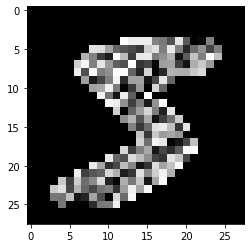

In [10]:
# Apply the sharpen filter to the example and save the output to sharpened_image
sharpened_image = scipy.ndimage.convolve(example, sharpen, mode='constant', cval=0.0)

plt.imshow(sharpened_image, cmap="gray")
plt.show()

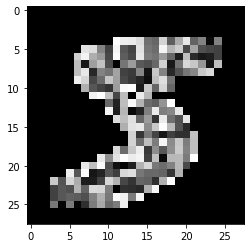

In [11]:
# Apply a filter of your choice (saved to my_filter) and save the output image to filtered_image
my_filter = np.array([
    [-1, 0, -1],
    [-1, 0, -1],
    [-1, 0, -1]
])
filtered_image = scipy.ndimage.convolve(example, my_filter, mode='constant', cval=0.0)

plt.imshow(filtered_image, cmap="gray")
plt.show()

In [12]:
assert sharpened_image.shape == example.shape
assert filtered_image.shape == example.shape
assert my_filter.shape == (3,3)

We'll start by creating a simple 2 hidden layer fully connected feed forward neural network.

In [13]:
# Create a simple NN model with 2 hidden dense layers and an output layer
# You can choose any number of neurons per Dense layer ex. 100 or 200
# This is a classification task with 10 output classes so make sure you adjust the last output layer's hyperparameters accordingly
# Since the input data is a matrix, you will want to use the Flatten layer 
# Save the layers of the model to simple_layers and the resulting Sequential model to simple_model

simple_layers = [Flatten(data_format=None),
                 Dense(100, activation="relu", name="layer1"),
                 Dropout(0.15, input_shape=(100,)),
                 Dense(100, activation="relu", name="layer2"),
                 Dropout(0.15, input_shape=(100,)),
                 Dense(10, activation="softmax", name="layer4")]

simple_model = Sequential(simple_layers)



simple_model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
simple_model.fit(x_train.astype(np.float32), y_train.astype(np.float32), epochs=5)
simple_model.summary()

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 5s 76us/sample - loss: 2.1079 - accuracy: 0.6762
Epoch 2/5
60000/60000 [==============================] - 4s 70us/sample - loss: 0.6644 - accuracy: 0.8327
Epoch 3/5
60000/60000 [==============================] - 4s 66us/sample - loss: 0.4730 - accuracy: 0.8796
Epoch 4/5
60000/60000 [==============================] - 4s 69us/sample - loss: 0.3894 - accuracy: 0.8968
Epoch 5/5
60000/60000 [==============================] - 4s 67us/sample - loss: 0.3378 - accuracy: 0.9090
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            multiple                  0         
_________________________________________________________________
layer1 (Dense)               multiple                  78500     
_________________________________________________________________
dropout (Dropout)            mu

In [14]:
assert len(simple_layers) == 6
assert isinstance(simple_layers[0], Flatten)
assert isinstance(simple_layers[1], Dense)
assert isinstance(simple_layers[3], Dense)
assert isinstance(simple_layers[5], Dense)
assert isinstance(simple_layers[2], Dropout)
assert isinstance(simple_layers[4], Dropout)

simple_scores = simple_model.evaluate(x_test, y_test)
assert simple_scores[1] > 0.3

10000/10000 [==============================] - 1s 61us/sample - loss: 0.2215 - accuracy: 0.9401


In [15]:
print(f"\nThe simple model achieves an accuracy of {simple_scores[1]*100:.2f}% on the test data.")


The simple model achieves an accuracy of 94.01% on the test data.


What's a good accuracy for our model? Is 50% good? 

Something to consider is that we have 10 classes - does that change your answer? What would random guessing's accuracy be? 

Based on your answer to the above questions, is your simple model good? 

Let's see if we can do better. In the next section, we'll build a convolutional neural network. You'll need to use [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers from Keras. 

In [16]:
# Create a CNN model with 4 convolutional layers, 2 dense fully connected hidden layers and the output layer
# Use Max pooling after every convolutional layer and use 32, 64, 128, 128 filters respectively
# Note that the output of the convolutional layers is a tensor
# You will need to flatten the output from the feature learning component 
# You can choose any number of neurons per Dense layer ex. 100 or 200
# Save the layers of the cnn model to cnn_layers and the resulting Sequential model as cnn_model

cnn_layers = [Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=(28,28,1)),
                MaxPool2D(pool_size=(2, 2)),
                Conv2D(64, kernel_size=3, padding='same', activation='relu'),
                MaxPool2D(pool_size=(2, 2)),
                Conv2D(128, kernel_size=3, padding='same', activation='relu'),
                MaxPool2D(pool_size=(2, 2)),
                Conv2D(128, kernel_size=3, padding='same', activation="relu"),
                MaxPool2D(pool_size=(2, 2)),
                Flatten(data_format=None),
                Dense(100, activation="relu"),
                Dense(100, activation="relu"),
                Dense(10, activation="softmax")]

cnn_model  = Sequential(cnn_layers)
cnn_model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(x_train.reshape(-1, 28, 28 ,1), y_train, epochs=1)
cnn_model.summary()

Train on 60000 samples
60000/60000 [==============================] - 9s 143us/sample - loss: 0.2267 - accuracy: 0.9435
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 128)         0         


In [17]:
assert len(cnn_layers) == 12
assert isinstance(cnn_layers[0], Conv2D)
assert isinstance(cnn_layers[2], Conv2D)
assert isinstance(cnn_layers[4], Conv2D)
assert isinstance(cnn_layers[6], Conv2D)
assert isinstance(cnn_layers[1], MaxPool2D)
assert isinstance(cnn_layers[3], MaxPool2D)
assert isinstance(cnn_layers[5], MaxPool2D)
assert isinstance(cnn_layers[7], MaxPool2D)
assert isinstance(cnn_layers[8], Flatten)
assert isinstance(cnn_layers[9], Dense)
assert isinstance(cnn_layers[10], Dense)
assert isinstance(cnn_layers[11], Dense)

cnn_scores = cnn_model.evaluate(x_test.reshape(-1, 28, 28 ,1), y_test)
assert cnn_scores[1] > 0.9

10000/10000 [==============================] - 1s 89us/sample - loss: 0.1191 - accuracy: 0.9646


In [18]:
print(f"\nThe CNN model achieves an accuracy of {cnn_scores[1]*100:.2f}% on the test data.")


The CNN model achieves an accuracy of 96.46% on the test data.


The simple model predicts this number is a 1 and the CNN predicts it is a 1.


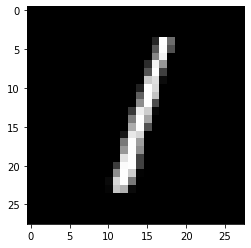

In [19]:
# Change this value to test out some numbers and see how the models do
i = 2

new_example = x_test[i]

simple_new_example = new_example.reshape(-1, 28, 28)
cnn_new_example=new_example.reshape(-1, 28, 28, 1)

simple_predict = simple_model.predict(simple_new_example).argmax()
cnn_predict = cnn_model.predict(cnn_new_example).argmax()

plt.imshow(new_example, cmap="gray")
print(f"The simple model predicts this number is a {simple_predict} and the CNN predicts it is a {cnn_predict}.")

## Feedback

In [20]:
def feedback():
    """Provide feedback on the contents of this exercise
    
    Returns:
        string
    """
    return "The most difficult part of this assignment was trying to figure out the arguements to pass, like padding and stride. I wish choosing these was specified in greater detail"
feedback()

'The most difficult part of this assignment was trying to figure out the arguements to pass, like padding and stride. I wish choosing these was specified in greater detail'